In [1]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

In [2]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
a= ZipFile("movielens.zip", "r").extractall()

In [3]:
users = pd.read_csv(
    "ml-1m/users.dat",
    sep="::",
    names=["user_id", "sex", "age_group", "occupation", "zip_code"],
)
ratings = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"], encoding='cp949'
)
movies = pd.read_csv("ml-1m/movies.dat", sep="::", encoding = 'iso-8859-1'
    , names=["movie_id", "title", "genres"]
)

<ipython-input-3-b221e29db572>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  users = pd.read_csv(
<ipython-input-3-b221e29db572>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv(
<ipython-input-3-b221e29db572>:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv("ml-1m/movies.dat", sep="::", encoding = 'iso-8859-1'


In [4]:
users["user_id"] = users["user_id"].apply(lambda x: f"user_{x}")
users["age_group"] = users["age_group"].apply(lambda x: f"group_{x}")
users["occupation"] = users["occupation"].apply(lambda x: f"occupation_{x}")

movies["movie_id"] = movies["movie_id"].apply(lambda x: f"movie_{x}")

ratings["movie_id"] = ratings["movie_id"].apply(lambda x: f"movie_{x}")
ratings["user_id"] = ratings["user_id"].apply(lambda x: f"user_{x}")
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [5]:
genres = [
    "Action", "Adventure", "Animation",
    "Children's", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir",
    "Horror", "Musical", "Mystery", "Romance",
    "Sci-Fi", "Thriller", "War", "Western"
]
for genre in genres:
  movies[genre] = movies['genres'].apply(lambda value: int(genre in value.split('|')))

In [6]:
movies.shape

(3883, 21)

In [7]:
ratings_group = ratings.sort_values(by='unix_timestamp').groupby('user_id')

In [8]:
ratings_data = pd.DataFrame(
    data={
        "user_id": list(ratings_group.groups.keys()),
        "movie_ids": list(ratings_group.movie_id.apply(list)),
        "ratings": list(ratings_group.rating.apply(list)),
        "timestamps": list(ratings_group.unix_timestamp.apply(list)),
    }
)
ratings_data.head()

,user_id,movie_ids,ratings,timestamps
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_102...","[4.0, 4.0, 5.0, 5.0, 3.0, 5.0, 4.0, 4.0, 5.0, ...","[978300019, 978300055, 978300055, 978300055, 9..."
1,user_10,"[movie_597, movie_858, movie_743, movie_1210, ...","[4.0, 3.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, 3.0, ...","[978224375, 978224375, 978224375, 978224400, 9..."
2,user_100,"[movie_260, movie_1676, movie_1198, movie_541,...","[4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 1.0, 1.0, 5.0, ...","[977593595, 977593595, 977593607, 977593624, 9..."
3,user_1000,"[movie_971, movie_260, movie_2990, movie_2973,...","[4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, 5.0, 5.0, ...","[975040566, 975040566, 975040566, 975040629, 9..."
4,user_1001,"[movie_1198, movie_1617, movie_2885, movie_390...","[4.0, 4.0, 4.0, 2.0, 2.0, 1.0, 4.0, 5.0, 5.0, ...","[975039591, 975039702, 975039702, 975039898, 9..."


In [9]:
sequence_length = 4
step_size = 2

def create_sequences(values, window_size, step_size):
  sequences = []
  start_index = 0
  while True:
    end_index = start_index + window_size
    seq = values[start_index:end_index]
    if len(seq)< window_size:
        seq = values[-window_size:] #마지막 시퀀스는 마지막 데이터까지 포함한다
        # window_size와 같으면 list에 붙여줍니다.
        if len(seq) == window_size:
            sequences.append(seq)
        break
    sequences.append(seq)
    start_index += step_size
  return sequences


ratings_data.movie_ids = ratings_data.movie_ids.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

ratings_data.ratings = ratings_data.ratings.apply(
    lambda ids: create_sequences(ids, sequence_length, step_size)
)

In [10]:
del ratings_data['timestamps'] #시계열로 정렬하였으니 삭제해도됨

In [11]:
ratings_data_movies = ratings_data[['user_id','movie_ids']].explode('movie_ids',ignore_index=True)
ratings_data_rating = ratings_data[['ratings']].explode('ratings',ignore_index=True)

In [12]:
ratings_data_transformed = pd.concat([ratings_data_movies,ratings_data_rating],axis=1)
ratings_data_transformed.head()

,user_id,movie_ids,ratings
0,user_1,"[movie_3186, movie_1721, movie_1270, movie_1022]","[4.0, 4.0, 5.0, 5.0]"
1,user_1,"[movie_1270, movie_1022, movie_2340, movie_1836]","[5.0, 5.0, 3.0, 5.0]"
2,user_1,"[movie_2340, movie_1836, movie_3408, movie_1207]","[3.0, 5.0, 4.0, 4.0]"
3,user_1,"[movie_3408, movie_1207, movie_2804, movie_260]","[4.0, 4.0, 5.0, 4.0]"
4,user_1,"[movie_2804, movie_260, movie_720, movie_1193]","[5.0, 4.0, 3.0, 5.0]"


In [13]:
##users.set_index('user_id')
ratings_data_transformed = ratings_data_transformed.join(users.set_index('user_id'), on='user_id')

In [14]:
ratings_data_transformed.movie_ids = ratings_data_transformed.movie_ids.apply(lambda x: ','.join(x))

In [15]:
ratings_data_transformed.ratings  = ratings_data_transformed.ratings.apply(lambda x: ','.join([str(v) for v in x]))

In [16]:
del ratings_data_transformed['zip_code']

In [17]:
ratings_data_transformed.rename(
    columns={"movie_ids": "sequence_movie_ids", "ratings": "sequence_ratings"},
    inplace=True,
)

In [18]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(ratings_data_transformed,test_size=0.15)
train.to_csv("train_data.csv", index=False, sep=",",header=False) #, sep="|", header=False
test.to_csv("test_data.csv", index=False,sep=",",header=False)

In [19]:
CSV_HEADER = list(ratings_data_transformed)

CATEGORICAL_FEATURES_WITH_VOCABULARY ={
    'user_id' : list(users.user_id.unique()),
    'movie_id' : list(movies.movie_id.unique()),
    'sex' : list(users.sex.unique()),
    'age_group' : list(users.age_group.unique()),
    'occupation' : list(users.occupation.unique())
}
USER_FEATURES = ['sex','age_group','occupation']
MOVIE_FEATURES = ['genres']

In [20]:
def get_dataset_from_csv(csv_path, shuffle = False, batch_size=128):
  def process(features):
    movie_ids_string =features['sequence_movie_ids'] 
    sequence_movie_ids = tf.strings.split(movie_ids_string,",").to_tensor() #RaggedTensor로 변하면 Indexing 불가
    features['target_movie_id'] = sequence_movie_ids[:,-1] #target 
    features['sequence_movie_ids'] = sequence_movie_ids[:,:-1] #
    ratings_string = features['sequence_ratings']
    sequence_ratings = tf.strings.to_number(
        tf.strings.split(ratings_string,','), 
        tf.dtypes.float32).to_tensor()
    target = sequence_ratings[:,-1]
    features['sequence_ratings'] = sequence_ratings[:,:-1]
    return features, target

  dataset = tf.data.experimental.make_csv_dataset(csv_path,batch_size=batch_size,column_names=CSV_HEADER,
                                      num_epochs=1,header=False,field_delim=',',shuffle=shuffle).map(process)
  return dataset

In [21]:
#Input Frame 생성
def create_model_inputs():
  return {
      'user_id' : layers.Input(name='user_id',shape=(1,),dtype=tf.string),
      'sequence_movie_ids' : layers.Input(
          name = 'sequence_movie_ids',shape=(sequence_length-1,), dtpye=tf.string
      ),
      'target_movie_id' : layers.Input(
          name='target_movie_id',shape=(1,),dtype=tf.string),
      'sequence_ratings' : layers.input(name='sequence_ratings',shape=(sequence_length-1,),dtype = tf.float32),
      'sex' : layers.Input(name='sex',shape=(1,),dtype=tf.string),
      'age_group' : layers.Input(name='age_group',shape=(1,),dtype = tf.string),
      'occupation' : layers.Input(name='occupation',shape=(1,),dtype = tf.string),
  }

In [22]:
def create_model_inputs():
    return {
        "user_id": layers.Input(name="user_id", shape=(1,), dtype=tf.string),
        "sequence_movie_ids": layers.Input(
            name="sequence_movie_ids", shape=(sequence_length - 1,), dtype=tf.string
        ),
        "target_movie_id": layers.Input(
            name="target_movie_id", shape=(1,), dtype=tf.string
        ),
        "sequence_ratings": layers.Input(
            name="sequence_ratings", shape=(sequence_length - 1,), dtype=tf.float32
        ),
        "sex": layers.Input(name="sex", shape=(1,), dtype=tf.string),
        "age_group": layers.Input(name="age_group", shape=(1,), dtype=tf.string),
        "occupation": layers.Input(name="occupation", shape=(1,), dtype=tf.string),
    }

In [23]:
def encode_input_features(inputs, include_user_id=True,include_user_features=True,include_movie_features=True):
  encoded_transformer_features = []
  encoded_other_features = [] #인코딩 레이어에서 생성되는 side info, main feature

  other_feature_names = []
  if include_user_id:
    other_feature_names.append('user_id')
  if include_user_features:
    other_feature_names.extend(USER_FEATURES)


  for feature_name in other_feature_names:
    vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
    idx = StringLookup(vocabulary=vocabulary,mask_token=None,num_oov_indices=0)(inputs[feature_name])
    #vocabulary에 없고 인덱스를 생성하면 num_oov_indice가 0일때 오류를 발생시킨다
    #oov 인덱스가 없는 단어들을 넣는 공간

    embedding_dims = int(math.sqrt(len(vocabulary))) #전체 단어의 sqrt 차원
    embedding_encoder = layers.Embedding(input_dim=len(vocabulary),
                                         output_dim=embedding_dims,
                                         name=f"{feature_name}_embedding")
    encoded_other_features.append(embedding_encoder(idx))
  if len(encoded_other_features) > 1:
    encoded_other_features = layers.concatenate(encoded_other_features)
  elif len(encoded_other_features) == 1:
    encoded_other_features = encoded_other_features[0]
  else:
    encoded_other_features = None
  movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY['movie_id']
  movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
  movie_index_lookup = StringLookup(vocabulary = movie_vocabulary, num_oov_indices=0,mask_token = None,name='movie_index_lookup')
  movie_embedding_encoder = layers.Embedding(input_dim = len(movie_vocabulary), output_dim = movie_embedding_dims,name = 'movie_embedding')
  genre_vector = movies[genres].to_numpy()
  movie_genre_lookup = layers.Embedding(input_dim = genre_vector.shape[0],output_dim = genre_vector.shape[1],
                                        embeddings_initializer = tf.keras.initializers.Constant(genre_vector),
                                        trainable = False, name='genre_vector')
  movie_embedding_processor = layers.Dense(units=movie_embedding_dims,activation = 'relu', name ='process_movie_embedding_with_genres') 
  #genre to movie

  def encode_movie(movie_id):
    movie_idx = movie_index_lookup(movie_id)
    movie_embedding = movie_embedding_encoder(movie_idx)
    encoded_movie = movie_embedding

    #장르를 Embedding에 포함시킨다면
    if include_movie_features:
      movie_genres_vector = movie_genre_lookup(movie_idx) #movie id를 장르 임베딩에 넣는이유
      encoded_movie = movie_embedding_processor(layers.concatenate([movie_embedding,movie_genres_vector]))
    return encoded_movie
  target_movie_id = inputs['target_movie_id']
  encoded_target_movie = encode_movie(target_movie_id)

  sequence_movies_ids = inputs['sequence_movie_ids']
  encoded_sequence_movies = encode_movie(sequence_movies_ids) #3이여야하는데

  #positional embedding layer
  position_embedding_encoder = layers.Embedding(input_dim = sequence_length, #3이여야하는데
                                                output_dim = movie_embedding_dims,
                                                name='position_embedding')

  positions = tf.range(start= 0, limit = sequence_length-1, delta = 1)
  encoded_positions = position_embedding_encoder(positions)

  sequence_ratings = tf.expand_dims(inputs['sequence_ratings'],-1) #차원 맞춰주기

  encoded_sequence_movies_with_position_and_rating = layers.Multiply()([(encoded_sequence_movies+encoded_positions),sequence_ratings])

  for encoded_movie in tf.unstack(encoded_sequence_movies_with_position_and_rating,axis=1):
    encoded_transformer_features.append(tf.expand_dims(encoded_movie,1))
  encoded_transformer_features.append(encoded_target_movie)

  encoded_transformer_features = layers.concatenate(encoded_transformer_features,axis=1)
  return encoded_transformer_features, encoded_other_features


In [24]:
def encode_input_features(
    inputs,
    include_user_id=True,
    include_user_features=True,
    include_movie_features=True,
):

    encoded_transformer_features = []
    encoded_other_features = []

    other_feature_names = []
    if include_user_id:
        other_feature_names.append("user_id")
    if include_user_features:
        other_feature_names.extend(USER_FEATURES)

    ## Encode user features
    for feature_name in other_feature_names:
        # Convert the string input values into integer indices.
        vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
        idx = StringLookup(vocabulary=vocabulary, mask_token=None, num_oov_indices=0)(
            inputs[feature_name]
        )
        # Compute embedding dimensions
        embedding_dims = int(math.sqrt(len(vocabulary)))
        # Create an embedding layer with the specified dimensions.
        embedding_encoder = layers.Embedding(
            input_dim=len(vocabulary),
            output_dim=embedding_dims,
            name=f"{feature_name}_embedding",
        )
        # Convert the index values to embedding representations.
        encoded_other_features.append(embedding_encoder(idx))

    ## Create a single embedding vector for the user features
    if len(encoded_other_features) > 1:
        encoded_other_features = layers.concatenate(encoded_other_features)
    elif len(encoded_other_features) == 1:
        encoded_other_features = encoded_other_features[0]
    else:
        encoded_other_features = None

    ## Create a movie embedding encoder
    movie_vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY["movie_id"]
    movie_embedding_dims = int(math.sqrt(len(movie_vocabulary)))
    # Create a lookup to convert string values to integer indices.
    movie_index_lookup = StringLookup(
        vocabulary=movie_vocabulary,
        mask_token=None,
        num_oov_indices=0,
        name="movie_index_lookup",
    )
    # Create an embedding layer with the specified dimensions.
    movie_embedding_encoder = layers.Embedding(
        input_dim=len(movie_vocabulary),
        output_dim=movie_embedding_dims,
        name=f"movie_embedding",
    )
    # Create a vector lookup for movie genres.
    genre_vectors = movies[genres].to_numpy()
    movie_genres_lookup = layers.Embedding(
        input_dim=genre_vectors.shape[0],
        output_dim=genre_vectors.shape[1],
        embeddings_initializer=tf.keras.initializers.Constant(genre_vectors),
        trainable=False,
        name="genres_vector",
    )
    # Create a processing layer for genres.
    movie_embedding_processor = layers.Dense(
        units=movie_embedding_dims,
        activation="relu",
        name="process_movie_embedding_with_genres",
    )

    ## Define a function to encode a given movie id.
    def encode_movie(movie_id):
        # Convert the string input values into integer indices.
        movie_idx = movie_index_lookup(movie_id)
        movie_embedding = movie_embedding_encoder(movie_idx)
        encoded_movie = movie_embedding
        if include_movie_features:
            movie_genres_vector = movie_genres_lookup(movie_idx)
            encoded_movie = movie_embedding_processor(
                layers.concatenate([movie_embedding, movie_genres_vector])
            )
        return encoded_movie

    ## Encoding target_movie_id
    target_movie_id = inputs["target_movie_id"]
    encoded_target_movie = encode_movie(target_movie_id)

    ## Encoding sequence movie_ids.
    sequence_movies_ids = inputs["sequence_movie_ids"]
    encoded_sequence_movies = encode_movie(sequence_movies_ids)
    # Create positional embedding.
    position_embedding_encoder = layers.Embedding(
        input_dim=sequence_length,
        output_dim=movie_embedding_dims,
        name="position_embedding",
    )
    positions = tf.range(start=0, limit=sequence_length - 1, delta=1)
    encodded_positions = position_embedding_encoder(positions)
    # Retrieve sequence ratings to incorporate them into the encoding of the movie.
    sequence_ratings = tf.expand_dims(inputs["sequence_ratings"], -1)
    # Add the positional encoding to the movie encodings and multiply them by rating.
    encoded_sequence_movies_with_poistion_and_rating = layers.Multiply()(
        [(encoded_sequence_movies + encodded_positions), sequence_ratings]
    )

    # Construct the transformer inputs.
    for encoded_movie in tf.unstack(
        encoded_sequence_movies_with_poistion_and_rating, axis=1
    ):
        encoded_transformer_features.append(tf.expand_dims(encoded_movie, 1))
    encoded_transformer_features.append(encoded_target_movie)

    encoded_transformer_features = layers.concatenate(
        encoded_transformer_features, axis=1
    )

    return encoded_transformer_features, encoded_other_features

In [25]:
include_user_id = False
include_user_features = False
include_movie_features = False

hidden_units = [256,128]
dropout_rate = 0.2
num_heads = 3 #?

def create_model():
  inputs = create_model_inputs()
  transformer_features, other_features = encode_input_features(
      inputs,include_user_id,include_user_features,include_movie_features
  )

  attention_output = layers.MultiHeadAttention(num_heads = num_heads, 
                                              key_dim=transformer_features.shape[2],
                                               dropout = dropout_rate)(transformer_features,transformer_features) #왜 같은 feature를 넣었을까?

  attention_output = layers.Dropout(dropout_rate)(attention_output)
  x1 = layers.Add()([transformer_features,attention_output])
  x1 = layers.LayerNormalization()(x1)
  x2 = layers.LeakyReLU()(x1)
  x2 = layers.Dense(units=x2.shape[-1])(x2)
  x2 = layers.Dropout(dropout_rate)(x2)
  transformer_features = layers.Add()([x1,x2])
  transformer_features = layers.LayerNormalization()(transformer_features)
  features = layers.Flatten()(transformer_features)

  if other_features is not None:
    features = layers.concatenate([features,layers.Reshape([other_features.shape[-1]])(other_features)])
    #feature와 side info를 합치는 과정
  for num_units in hidden_units:
    features = layers.Dense(num_units)(features)
    features = layers.BatchNormalization()(features)
    features = layers.LeakyReLU()(features)
    features = layers.Dropout(dropout_rate)(features)

  outputs = layers.Dense(1)(features)
  model = keras.Model(inputs=inputs,outputs=outputs)
  return model

model = create_model()

/usr/local/lib/python3.9/dist-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


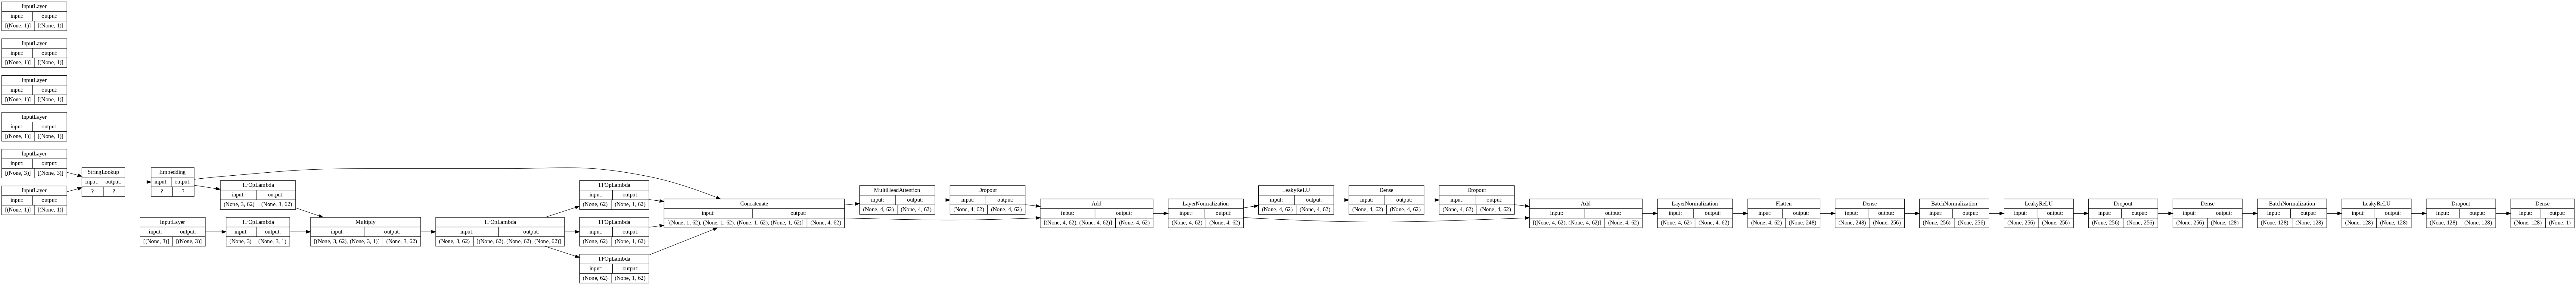

In [26]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, dpi=100, rankdir='LR')

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adagrad(learning_rate=0.01),
    loss = keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError()]
)

train_dataset = get_dataset_from_csv('train_data.csv',shuffle=True,batch_size=256)
model.fit(train_dataset,epochs=5)

Epoch 1/5
1656/1656 [==============================] - 86s 50ms/step - loss: 1.1016 - mean_absolute_error: 0.8401
Epoch 2/5
1656/1656 [==============================] - 85s 51ms/step - loss: 0.9960 - mean_absolute_error: 0.7975
Epoch 3/5
1656/1656 [==============================] - 81s 49ms/step - loss: 0.9578 - mean_absolute_error: 0.7810
Epoch 4/5
1656/1656 [==============================] - 81s 49ms/step - loss: 0.9367 - mean_absolute_error: 0.7722
Epoch 5/5
1656/1656 [==============================] - 83s 50ms/step - loss: 0.9223 - mean_absolute_error: 0.7654


In [ ]:
# Read the test data.
test_dataset = get_dataset_from_csv("test_data.csv", batch_size=265)

# Evaluate the model on the test data.
_, rmse = model.evaluate(test_dataset, verbose=0)
print(f"Test MAE: {round(rmse, 3)}")

Test MAE: 0.761


In [ ]:
#csv 저장할때 header가 문제였어 -> 블로그 올리자